In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random

import matplotlib.pyplot as plt

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [45]:
seed = 42
feature_size = 24
baseline_accuracy = 0.8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

random.seed(seed)
torch_seed = random.randint(0, 2 ** 32 - 1)
numpy_seed = random.randint(0, 2 ** 32 - 1)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_seed)
np.random.seed(numpy_seed)

Using device: cpu


In [46]:
class SigmoidNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, layer_size: int = 64):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1),
        )

        self.layers.apply(self._init_weights)

    def forward(self, x):
        return self.layers(x).view(-1)
    
    def clasiffy(self, x):
        return torch.round(nn.Sigmoid()(self.forward(x))).view(-1).long()
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

In [ ]:
def load_data(feature_size: int):
    X = np.load('../Datasets/kryptonite-%s-X.npy'%(feature_size))
    y = np.load('../Datasets/kryptonite-%s-y.npy'%(feature_size))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = np.where(X_train >= 0, np.float32(1.0), np.float32(-1.0))
    X_test = np.where(X_test >= 0, np.float32(1.0), np.float32(-1.0))

    return X_train, y_train, X_test, y_test

In [48]:
X_train, y_train, X_test, y_test = load_data(feature_size)

38400 38400
9600 9600
38400 38400
9600 9600


In [49]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
)

params = {
    'optimizer__lr': [0.01],
    'max_epochs': [100],
    'batch_size': [4096],
    'module__layer_size': [256],
    'optimizer__weight_decay': [1e-3],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [50]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 4096, 'max_epochs': 100, 'module__layer_size': 256, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.63578125


In [51]:
from skorch.callbacks import EpochScoring

net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=100,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=gs.best_params_['optimizer__lr'],
    optimizer__weight_decay=gs.best_params_['optimizer__weight_decay'],
    batch_size=gs.best_params_['batch_size'],
    module__input_size=feature_size,
    module__layer_size=gs.best_params_['module__layer_size'],
    device=device,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
    ],
)

net = net.fit(X_train, y_train.astype(float))

C:\Users\liza\AppData\Local\Temp\ipykernel_3444\1082932622.py:25: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.5000        1.0461       0.4970        0.6931  0.4833
      2       0.4982        0.6933       0.5039        0.6932  0.4560
      3       0.5038        0.6931       0.4909        0.6932  0.4675
      4       0.5112        0.6929       0.4982        0.6933  0.4769
      5       0.5134        0.6927       0.5003        0.6934  0.4362
      6       0.5209        0.6924       0.4986        0.6935  0.4595
      7       0.5258        0.6921       0.4974        0.6936  0.4624
      8       0.5280        0.6915       0.4958        0.6940  0.4454
      9       0.5329        0.6907       0.4964        0.6947  0.6551
     10       0.5374        0.6898       0.5014        0.6958  0.4149
     11       0.5397        0.6891       0.4992        0.6959  0.4427
     12       0.5442        0.6882       0.5022        0.6966  0.4361
     13       0.5456

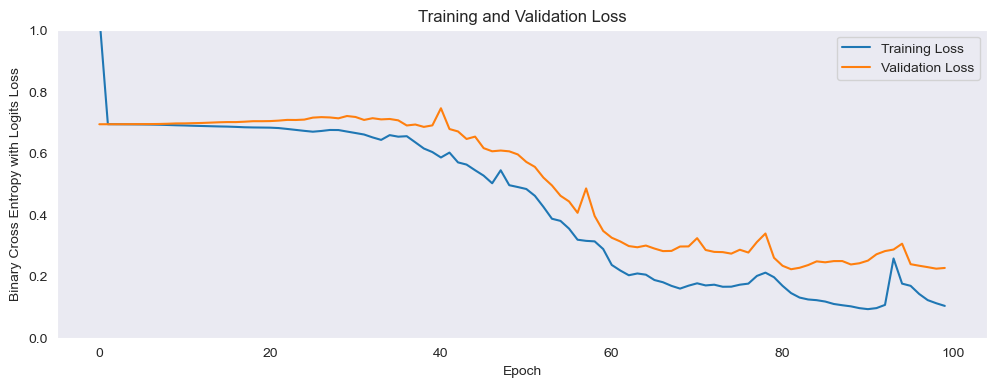

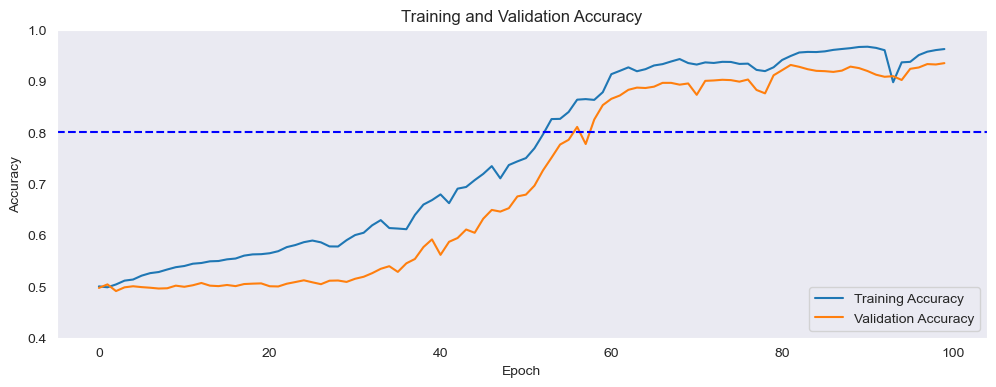

In [52]:
train_loss = net.history[:, 'train_loss']
valid_loss = net.history[:, 'valid_loss']

train_acc = net.history[:, 'train_acc']
valid_acc = net.history[:, 'valid_acc']

plt.figure(figsize=(12, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy with Logits Loss")
plt.ylim(0, 1.0)
plt.grid()
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.axhline(y=baseline_accuracy, color='b', linestyle='--')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.grid()
plt.legend(loc='lower right')
plt.show()
